In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
studentinfo = pd.read_csv("/Users/yanzhen/Desktop/studentInfo.csv")
registration = pd.read_csv("/Users/yanzhen/Desktop/studentRegistration.csv")

### Content-Based Recommender

In [19]:
edu_mapping = {'HE Qualification':1, 'A Level or Equivalent':2, 'Lower Than A Level':3, 'Post Graduate Qualification':4, 'No Formal quals':5}
studentinfo['highest_education'] = studentinfo['highest_education'].map(edu_mapping)
result_mapping = {'Pass':3, 'Withdrawn':1, 'Fail':2, 'Distinction':4} 
studentinfo['final_result'] = studentinfo['final_result'].map(result_mapping)

In [20]:
studentinfo

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,1,90-100%,55<=,0,240,N,3
1,AAA,2013J,28400,F,Scotland,1,20-30%,35-55,0,60,N,3
2,AAA,2013J,30268,F,North Western Region,2,30-40%,35-55,0,60,Y,1
3,AAA,2013J,31604,F,South East Region,2,50-60%,35-55,0,60,N,3
4,AAA,2013J,32885,F,West Midlands Region,3,50-60%,0-35,0,60,N,3
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,3,10-20,0-35,0,30,N,2
32589,GGG,2014J,2645731,F,East Anglian Region,3,40-50%,35-55,0,30,N,4
32590,GGG,2014J,2648187,F,South Region,2,20-30%,0-35,0,30,Y,3
32591,GGG,2014J,2679821,F,South East Region,3,90-100%,35-55,0,30,N,1


We select final results and studied credits as two predictors to calculate the similarity of courses. Since they indicate the difficulty of the courses to some extent, users who share similar credits and grades are likely to adapt to courses of similar difficulty.

In [21]:
studentinfo.groupby([studentinfo.code_module]).final_result.mean()

code_module
AAA    2.600267
BBB    2.258313
CCC    2.045332
DDD    2.118463
EEE    2.437628
FFF    2.246715
GGG    2.638516
Name: final_result, dtype: float64

In [22]:
studentinfo.groupby([studentinfo.code_module]).studied_credits.mean()

code_module
AAA    84.438503
BBB    84.072576
CCC    77.487596
DDD    86.647800
EEE    65.436264
FFF    90.845143
GGG    34.459353
Name: studied_credits, dtype: float64

In [23]:
data = pd.DataFrame({'final_result': [2.600267, 2.258313, 2.045332, 2.118463, 2.437628, 2.246715, 2.638516],
                     'studied_credits': [84.438503, 84.072576, 77.487596, 86.647800, 65.436264, 90.845143, 34.459353]})
data

,final_result,studied_credits
0,2.600267,84.438503
1,2.258313,84.072576
2,2.045332,77.487596
3,2.118463,86.647800
4,2.437628,65.436264
5,2.246715,90.845143
6,2.638516,34.459353


In [24]:
data.index = ['AAA', 'BBB','CCC','DDD','EEE','FFF','GGG']
data

,final_result,studied_credits
AAA,2.600267,84.438503
BBB,2.258313,84.072576
CCC,2.045332,77.487596
DDD,2.118463,86.647800
EEE,2.437628,65.436264
FFF,2.246715,90.845143
GGG,2.638516,34.459353


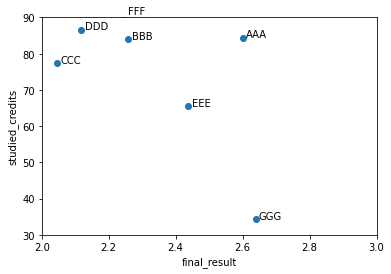

In [26]:
plt.scatter(data.final_result, data.studied_credits)

for i, index in enumerate (data.index):
    plt.text(data.final_result[i]+0.01, data.studied_credits[i]+0.01, index)
    
plt.xlim (2.0, 3.0)
plt.ylim (30, 90)
plt.xlabel("final_result")
plt.ylabel("studied_credits");

In [29]:
import math 

data_distance = data.copy()
data_distance['distance'] = 0

item = data_distance.loc['AAA']

for i in data_distance.index:
    target = data_distance.loc[i,]
    d = math.dist(item, target)
    data_distance.loc[i, 'distance'] = d

data_distance.sort_values('distance', ascending=True)

,final_result,studied_credits,distance
AAA,2.600267,84.438503,0.000000
BBB,2.258313,84.072576,0.500834
DDD,2.118463,86.647800,2.261223
FFF,2.246715,90.845143,6.416388
CCC,2.045332,77.487596,6.973024
EEE,2.437628,65.436264,19.002935
GGG,2.638516,34.459353,49.979165


We want to see the distance/similarity of other courses with AAA, so we set the distance of AAA equals to 0. Based on the final results and studied credits, BBB has the shortest distance to AAA, and GGG has the longest distance to AAA. Therefore, we can conclude that BBB is preferably recommended to students who have taken AAA. We can also set other courses as the control group and see the distance between the rest of the courses. These analysis is based on the record and data of students who have already registered and prior learning history.

### Collaborative Filter

In [90]:
data1 = studentinfo[['id_student', 'highest_education']]
data1

,id_student,highest_education
0,11391,1
1,28400,1
2,30268,2
3,31604,2
4,32885,3
...,...,...
32588,2640965,3
32589,2645731,3
32590,2648187,2
32591,2679821,3


In [91]:
data1_na = data1.dropna()
data1_na.index = data1_na.id_student
data1_clean = data1_na.drop('id_student', axis=1)

In [92]:
def get_recommendations(id_student, cosine_sim, matrix_indices):
    idx = matrix_indices[id_student]

In [93]:
cosine_sim_data1 = cosine_similarity(data1_clean, data1_clean)
id_student_indices = pd.Series(range(len(data1_clean.index)), index = data1_clean.index)

get_recommendations("11391", cosine_sim_data1, id_student_indices)

We would like to use collaborative filter to predict the preference of learners who have not registered yet. We will compare the highest education record of these learners with registered users and select similar group of people. The new learners will be recommended to the courses that been taken by the similar group of users. 